<h2>Read and play the signals</h2>

In [21]:
import numpy as np
import matplotlib.pylab as plt
import scipy
import librosa
import librosa.display
from IPython.core.display import display
import IPython.display as ipd

C:\Users\imane\AppData\Local\Temp\ipykernel_22276\1039096131.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [7]:
sig_noisy_path= "train_small_noise/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav"
sig_path= "train_small/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav"

fs_noisy, sig_noisy = scipy.io.wavfile.read(sig_noisy_path)
fs, sig = scipy.io.wavfile.read(sig_path)

print("noisy singnal:")
display(ipd.Audio(data= sig_noisy, rate= fs))
print("original signal:")
display(ipd.Audio(data= sig, rate=fs))

noisy singnal:


original signal:


In [9]:
print('teh shape of the original signal is: {}'.format(sig.shape))
print(" the sampling frequency is: {}".format(fs))


teh shape of the original signal is: (80000,)
 the sampling frequency is: 8000


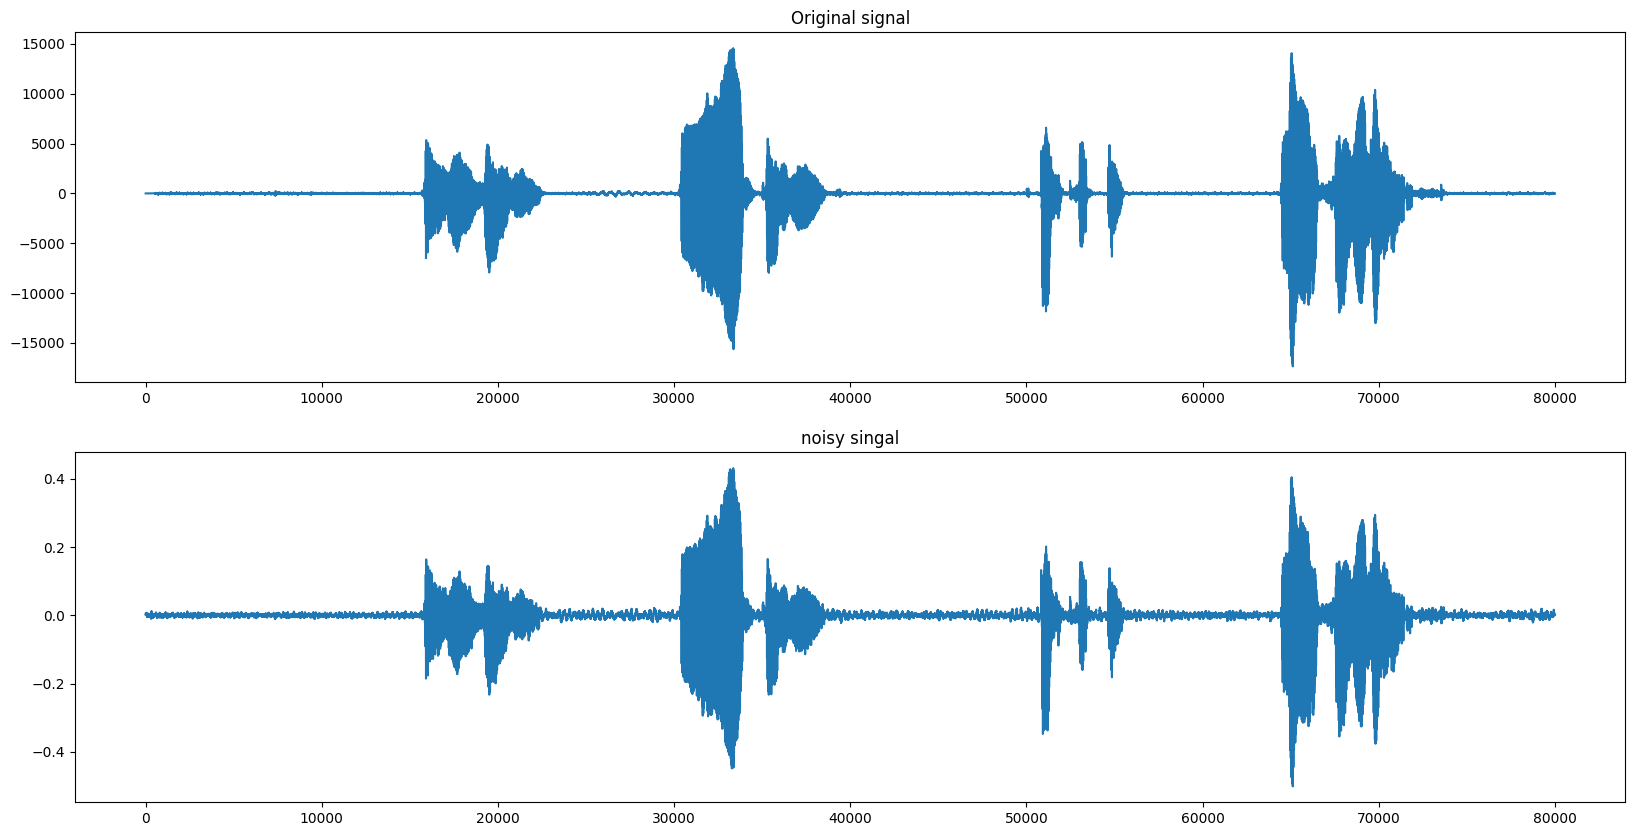

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(sig, label='orginal signal')
plt.title('Original signal')

plt.subplot(2,1,2)
plt.plot(sig_noisy)
plt.title("noisy singal")
plt.show()

<h2>Get the spectrograms and visualze:

Text(0, 0.5, 'Mel')

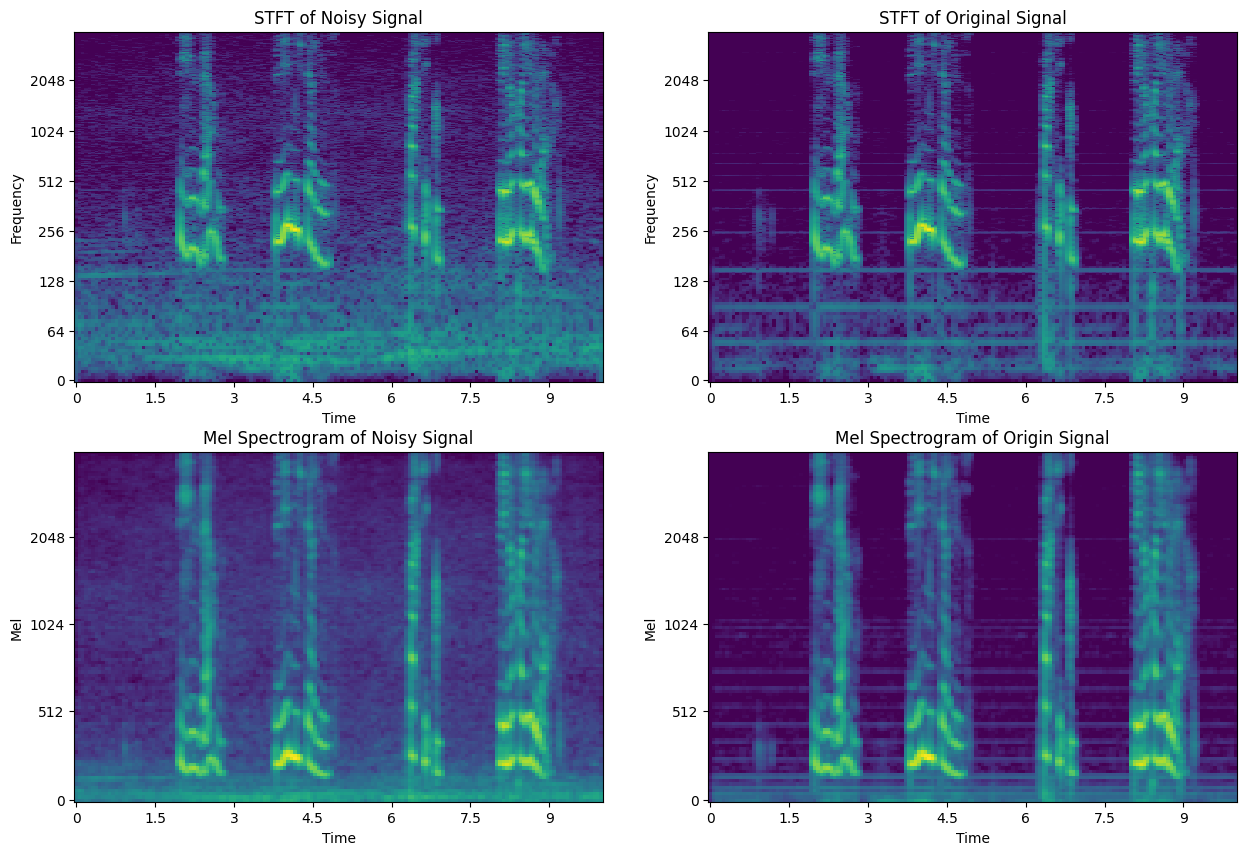

In [28]:
#get stft
stft_noisy= librosa.stft(sig_noisy.astype(float))
stft_origin= librosa.stft(sig.astype(float))
# get the mel
mel_noisy= librosa.feature.melspectrogram(y=sig_noisy.astype(float), sr= fs_noisy)
mel_origin= librosa.feature.melspectrogram(y=sig.astype(float), sr= fs)


# Displaying the results
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

librosa.display.specshow(librosa.amplitude_to_db(abs(stft_noisy)),
                         sr=fs_noisy, x_axis='time', y_axis='log', ax=ax[0, 0], cmap='viridis')
ax[0, 0].set_title('STFT of Noisy Signal')
ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Frequency')

librosa.display.specshow(librosa.amplitude_to_db(abs(stft_origin)),
                         sr=fs, x_axis='time', y_axis='log', ax=ax[0, 1], cmap='viridis')
ax[0, 1].set_title('STFT of Original Signal')
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Frequency')

librosa.display.specshow(librosa.power_to_db(mel_noisy),
                         sr=fs_noisy, x_axis='time', y_axis='mel', ax=ax[1, 0], cmap='viridis')
ax[1, 0].set_title('Mel Spectrogram of Noisy Signal')
ax[1, 0].set_xlabel('Time')
ax[1, 0].set_ylabel('Mel')

librosa.display.specshow(librosa.power_to_db(mel_origin),
                         sr=fs_noisy, x_axis='time', y_axis='mel', ax=ax[1, 1], cmap='viridis')
ax[1, 1].set_title('Mel Spectrogram of Origin Signal')
ax[1, 1].set_xlabel('Time')
ax[1, 1].set_ylabel('Mel')

We can clearly differentiate between some features of the original signal and noisy signal

In [ ]:
## store the spectrogram images


<h2>Train baseline model</h2>